In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [2]:
D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
# Define model
name = "V1_Circuit"
model = Model(name, parameters)

In [4]:
npzfile = np.load('SV_mode.npz')
z_mode = npzfile['z_mode']
h = z_mode[:,:4]
h1 = h.copy()
h2 = h.copy()
h2[:,:2] += z_mode[:,4:]


In [13]:
from epi.example_eps import euler_sim, euler_sim_traj
import tensorflow as tf

X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))

def V1_all_dr_eps(inc_val, h=np.array([1., 1., 1., 1.25])):

    h = tf.constant(h[None,:,None], dtype=tf.float32)

    def dr(dh):
        dh = dh[:, :, None]

        n = 2.
        epsilon = 0.05
        dt = 0.005
        T = 100
        tau = 0.02

        _x_shape = tf.ones_like(dh, dtype=tf.float32)
        x_init = _x_shape*X_INIT

        npzfile = np.load("data/V1_Zs.npz")
        _W = npzfile["Z_allen_square"][None, :, :]
        _W[:, :, 1:] = -_W[:, :, 1:]
        W = tf.constant(_W, dtype=tf.float32)

        def f1(y):
            omega = tf.random.normal(y.shape, 0., 1.)
            noise = epsilon*omega
            return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau

        def f2(y):
            omega = tf.random.normal(y.shape, 0., 1.)
            noise = epsilon*omega
            return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

        x1 = euler_sim(f1, x_init, dt, T)
        x2 = euler_sim(f2, x_init, dt, T)

        diff = x2 - x1
        T_x = tf.concat((diff, (diff - inc_val) ** 2), axis=1)

        return T_x
    return dr



E: 2 710/500
P: 6 583/500
S: 16 533/500
V: 17 506/500


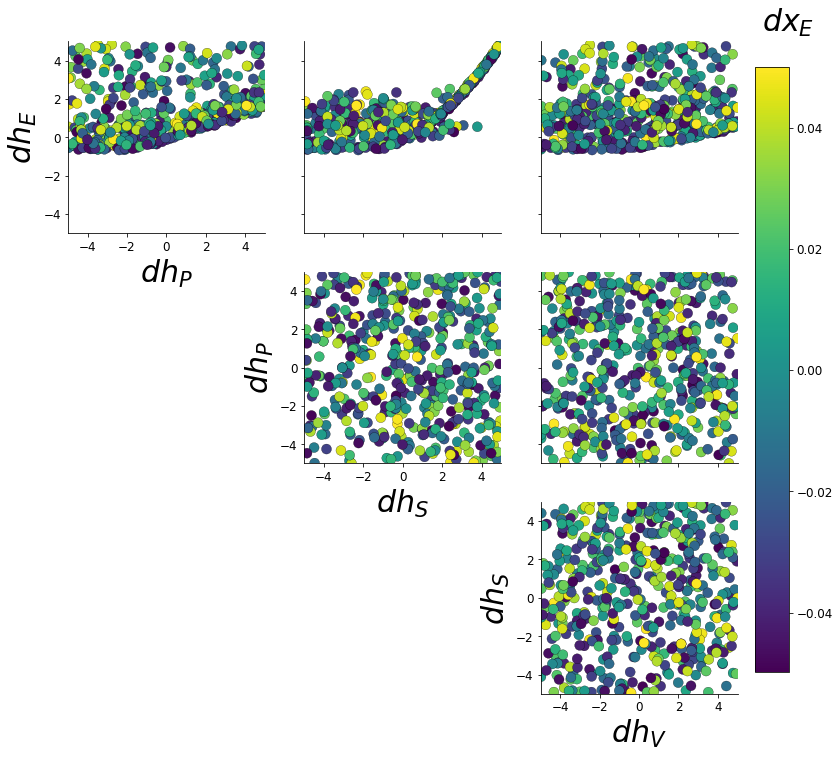

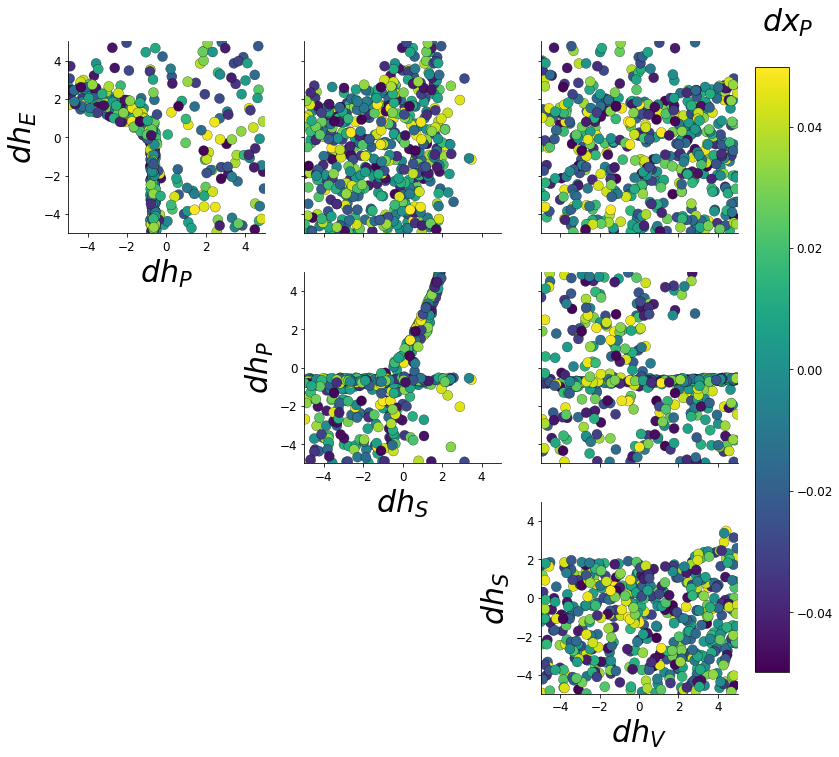

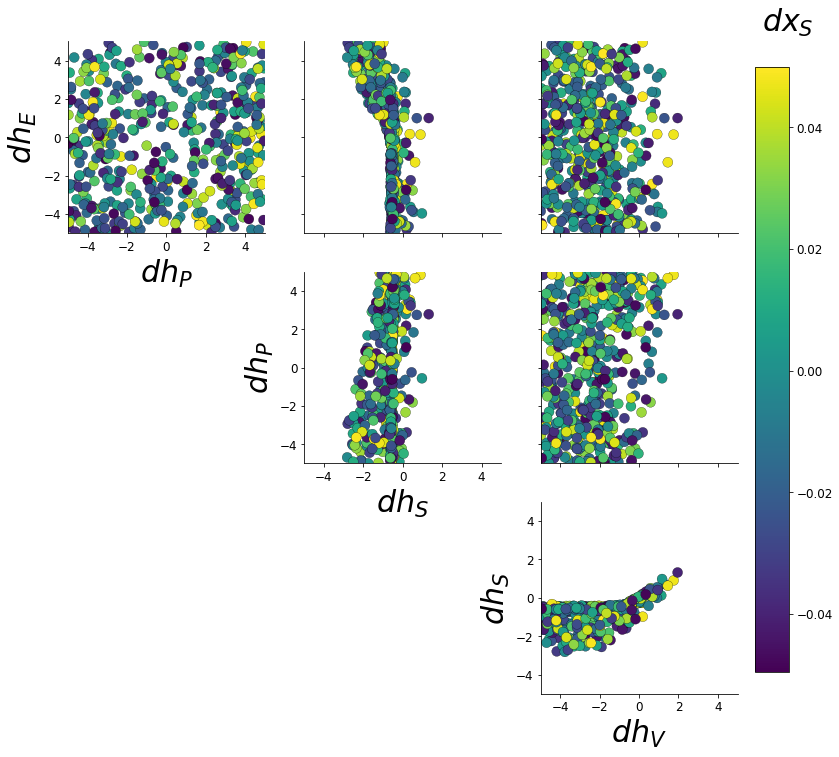

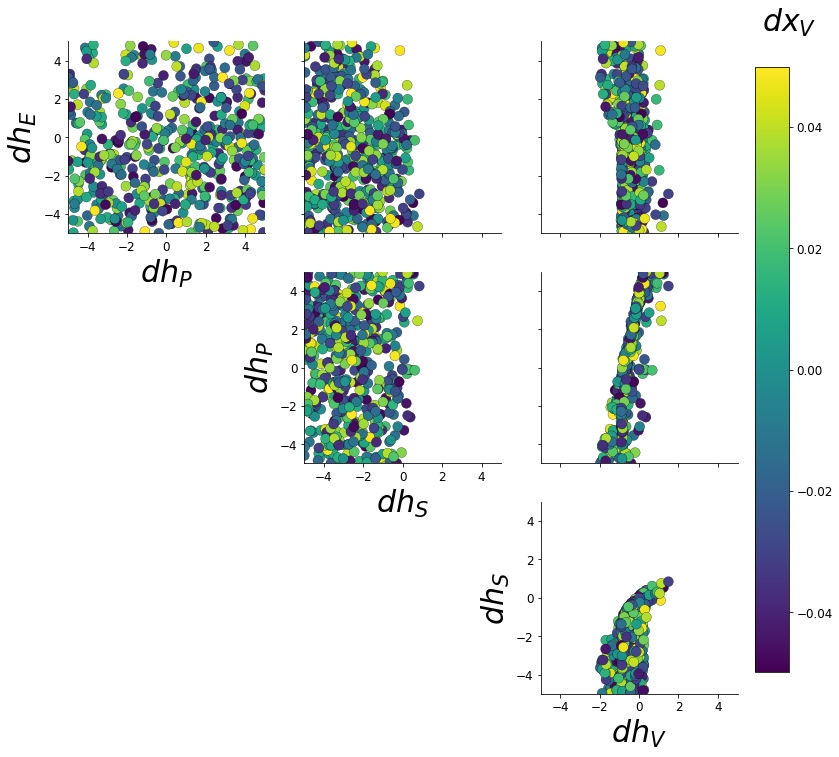

In [16]:
inc_val = 0.0
dr_all = V1_all_dr_eps(inc_val, h=h1[0])
model.set_eps(dr_all)


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_val, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(inc_val-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < inc_val+2*inc_std)


alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)
num_keep = int(5e2)
num_plot = int(5e2)
M = 20000
zs = []
T_xs = []

inc_stds = [0.025]
num_inc_std = len(inc_stds)

for k in range(num_inc_std):
    inc_std = inc_stds[k]
    zs_i = []
    T_xs_i = []
    for i in range(num_alphas):
        alpha = alphas[i]
        #M = Ms[k][i]
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        count = 0
        while (num_found < num_keep):
            count += 1
            _z = np.zeros((M, D))
            for j in range(D):
                _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
            _T_x = model.eps(_z).numpy()

            inds = accept_inds(_T_x, alpha, inc_val, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_i.append(z)
        T_xs_i.append(T_x)

        negd = -np.square(T_x[:,neuron_ind])
        z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels,
                       fontsize=fontsize, lb=lb, ub=ub,
                       c = T_x[:,neuron_ind],
                       c_label=r'$dx_%s$' % alpha)
        print('')
    
    zs.append(zs_i)
    T_xs.append(T_xs_i)